# Euro 2024 Game XGoals Analysis

In this notebook, we will perform a comprehensive analysis of a Euro 2024 match. Our goal is to extract and visualize Xgoals insights from the game, including:

1. **Scorers of the Match**  
   We'll identify the players who scored during the match and provide a summary of their performance.

2. **xG (Expected Goals) per Minute Graph**  
   We will create a graph to track the expected goals (xG) throughout the match, plotting the xG for each team per minute of the game. This will help in understanding the flow of the game and which team created more quality chances over time.

3. **Pitch Graph - xG by Location**  
   Using a pitch map, we'll visualize the xG for each team based on their shot locations. Each shot will be represented as a circle, with the size of the circle reflecting the xG value. This will help us analyze:
   - Where the shots were taken from.
   - How likely each shot was to result in a goal based on xG.

By the end of this analysis, we will have a detailed understanding of the performance of each team, their attacking effectiveness, and key moments that influenced the match.

Let's dive in!


## Import Libraries

In [1]:
from statsbombpy import sb
import pandas as pd
import numpy as np
#from mplsoccer import Pitch
from mplsoccer import VerticalPitch,Pitch
from mplsoccer.pitch import Pitch
from highlight_text import ax_text, fig_text
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
import math

pd.set_option("display.max_columns", None)

### Euro 2024 Competition

In [2]:
#call the statsbombpy API to get a list of matches for a given competition
euro_2024_matches = sb.matches(competition_id=55, season_id=282)

#print the first 5 matches listed
euro_2024_matches.head(5)

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3942819,2024-07-10,22:00:00.000,Europe - UEFA Euro,2024,Netherlands,England,1,2,available,available,2024-07-15T07:54:23.583297,2024-07-15T07:57:36.684453,6,Semi-finals,Signal-Iduna-Park,Felix Zwayer,Ronald Koeman,Gareth Southgate,1.1.0,2,2
1,3943043,2024-07-14,22:00:00.000,Europe - UEFA Euro,2024,Spain,England,2,1,available,available,2024-07-15T15:48:50.315500,2024-07-15T15:52:24.778809,7,Final,Olympiastadion Berlin,François Letexier,Luis de la Fuente Castillo,Gareth Southgate,1.1.0,2,2
2,3942752,2024-07-09,22:00:00.000,Europe - UEFA Euro,2024,Spain,France,2,1,available,available,2024-07-10T08:51:07.032303,2024-07-10T13:01:26.597509,6,Semi-finals,Allianz Arena,Slavko Vinčić,Luis de la Fuente Castillo,Didier Deschamps,1.1.0,2,2
3,3942382,2024-07-06,22:00:00.000,Europe - UEFA Euro,2024,Netherlands,Turkey,2,1,available,available,2024-07-10T06:50:04.068615,2024-07-10T06:56:35.146850,5,Quarter-finals,Olympiastadion Berlin,Clément Turpin,Ronald Koeman,Vincenzo Montella,1.1.0,2,2
4,3942349,2024-07-05,22:00:00.000,Europe - UEFA Euro,2024,Portugal,France,0,0,available,available,2024-07-12T01:57:15.210934,2024-07-12T02:00:16.871522,5,Quarter-finals,Volksparkstadion,Michael Oliver,Roberto Martínez Montoliú,Didier Deschamps,1.1.0,2,2


## ETL

In [3]:
#concat home and away teams to keep the unique teams that participated to the tournament
home_team = euro_2024_matches['home_team']
away_team = euro_2024_matches['away_team']
teams = pd.concat([home_team,away_team])
teams = pd.DataFrame(teams.drop_duplicates()).reset_index(drop=True)
teams.columns = ['Team']

In [4]:
# give teams colors for the visuals
team_colors = pd.read_excel('Team Colors.xlsx')
teams = teams.merge(team_colors, how='inner', on='Team')

In [5]:
teams.head()

,Team,First_Color,Second_Color
0,Netherlands,#F36C21,#FFFFFF
1,Spain,#8B0D11,#FCB507
2,Portugal,#E42518,#0D6938
3,Denmark,#FCB507,#FFFFFF
4,England,#000040,#FFFFFF


In [6]:
# take all matches in one dataframe
matches = euro_2024_matches.filter(['match_id','match_date','home_team','away_team','competition_stage','home_score','away_score','period'])
matches['match'] = matches['competition_stage'] + ' ' + matches['home_team'] + ' - ' + matches['away_team'] 

In [7]:
matches

,match_id,match_date,home_team,away_team,competition_stage,home_score,away_score,match
0,3942819,2024-07-10,Netherlands,England,Semi-finals,1,2,Semi-finals Netherlands - England
1,3943043,2024-07-14,Spain,England,Final,2,1,Final Spain - England
2,3942752,2024-07-09,Spain,France,Semi-finals,2,1,Semi-finals Spain - France
3,3942382,2024-07-06,Netherlands,Turkey,Quarter-finals,2,1,Quarter-finals Netherlands - Turkey
4,3942349,2024-07-05,Portugal,France,Quarter-finals,0,0,Quarter-finals Portugal - France
5,3930180,2024-06-25,Netherlands,Austria,Group Stage,2,3,Group Stage Netherlands - Austria
6,3930171,2024-06-20,Denmark,England,Group Stage,1,1,Group Stage Denmark - England
7,3942227,2024-07-06,England,Switzerland,Quarter-finals,1,1,Quarter-finals England - Switzerland
8,3942226,2024-07-05,Spain,Germany,Quarter-finals,2,1,Quarter-finals Spain - Germany
9,3938645,2024-06-26,Ukraine,Belgium,Group Stage,0,0,Group Stage Ukraine - Belgium


In [8]:
# functions fore retreiving match data

# retrieve the prefered Match ID
def take_matchid(df, value):
    match = df[df['match'] == value]
    if not match.empty:
        return match['match_id'].iloc[0]
    else:
        return None  # or handle it as you need

# select the match that you want 
def teams_selected(df,value):
    df_details = df[df.match == value]
    return df_details

In [9]:
# choose a match from table (matches) and column (match)
match_selector = 'Final Spain - England'

In [10]:
# call the statsbombpy events API to bring in the event data for the match using the function and the string match_selector
match = sb.events(match_id=take_matchid(matches,match_selector))

In [11]:
match.head()

,50_50,ball_receipt_outcome,ball_recovery_recovery_failure,block_deflection,block_offensive,block_save_block,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_right_foot,counterpress,dribble_nutmeg,dribble_outcome,dribble_overrun,duel_outcome,duel_type,duration,foul_committed_advantage,foul_committed_card,foul_committed_offensive,foul_won_advantage,foul_won_defensive,goalkeeper_body_part,goalkeeper_end_location,goalkeeper_outcome,goalkeeper_position,goalkeeper_technique,goalkeeper_type,id,index,injury_stoppage_in_chain,interception_outcome,location,match_id,minute,off_camera,out,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_end_location,pass_goal_assist,pass_height,pass_inswinging,pass_length,pass_no_touch,pass_outcome,pass_outswinging,pass_recipient,pass_recipient_id,pass_shot_assist,pass_switch,pass_technique,pass_through_ball,pass_type,period,play_pattern,player,player_id,position,possession,possession_team,possession_team_id,related_events,second,shot_aerial_won,shot_body_part,shot_deflected,shot_end_location,shot_first_time,shot_freeze_frame,shot_key_pass_id,shot_one_on_one,shot_outcome,shot_statsbomb_xg,shot_technique,shot_type,substitution_outcome,substitution_outcome_id,substitution_replacement,substitution_replacement_id,tactics,team,team_id,timestamp,type,under_pressure
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50aa204f-5d65-4145-8597-5d5628fb7898,1,NaN,NaN,NaN,3943043,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,1,Spain,772,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'formation': 4231, 'lineup': [{'player': {'id...",Spain,772,00:00:00.000,Starting XI,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a279cbee-9ab3-4cfb-9c51-27cacc1bf2a2,2,NaN,NaN,NaN,3943043,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,1,Spain,772,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'formation': 4231, 'lineup': [{'player': {'id...",England,768,00:00:00.000,Starting XI,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,d2126e70-9f04-4bb7-ba2b-9377836d1757,3,NaN,NaN,NaN,3943043,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,1,Spain,772,[54d78bfa-4146-42bd-acdc-97bcd393dd81],0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,England,768,00:00:00.000,Half Start,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54d78bfa-4146-42bd-acdc-97bcd393dd81,4,NaN,NaN,NaN,3943043,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,1,Spain,772,[d2126e70-9f04-4bb7-ba2b-9377836d1757],0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spain,772,00:00:00.000,Half Start,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7230470a-8ceb-4eb8-a66f-d72a2afb12d6,1706,NaN,NaN,NaN,3943043,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,Regular Play,NaN,NaN,NaN,79,Spain,772,[cb9ba06c-a673-448d-ab21-755d330fcadc],0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,England,768,00:00:00.000,Half Start,NaN


In [12]:
# retieve the general info of the match using again the other function and the match selector
match_details = teams_selected(matches,match_selector)

In [13]:
match_details

,match_id,match_date,home_team,away_team,competition_stage,home_score,away_score,match
1,3943043,2024-07-14,Spain,England,Final,2,1,Final Spain - England


In [14]:
# filter the columns that will need
shots_xg = match[['location', 'minute', 'player', 'team', 'shot_outcome', 'shot_statsbomb_xg', 'shot_technique', 'shot_type','period']]
shots_xg.head()

,location,minute,player,team,shot_outcome,shot_statsbomb_xg,shot_technique,shot_type,period
0,NaN,0,NaN,Spain,NaN,NaN,NaN,NaN,1
1,NaN,0,NaN,England,NaN,NaN,NaN,NaN,1
2,NaN,0,NaN,England,NaN,NaN,NaN,NaN,1
3,NaN,0,NaN,Spain,NaN,NaN,NaN,NaN,1
4,NaN,45,NaN,England,NaN,NaN,NaN,NaN,2


In [15]:
# remove if penalyty shotout exists in th end
shots_xg = shots_xg[shots_xg.period != 5]

In [16]:
# keep only the shots by removing nulls of shot_outcome column
shots_xg = shots_xg[shots_xg['shot_outcome'].isnull()==False].reset_index()
shots_xg.head()

,index,location,minute,player,team,shot_outcome,shot_statsbomb_xg,shot_technique,shot_type,period
0,3228,"[115.6, 28.4]",11,Nicholas Williams Arthuer,Spain,Blocked,0.068030,Normal,Open Play,1
1,3229,"[112.9, 36.2]",12,Robin Aime Robert Le Normand,Spain,Off T,0.117465,Overhead Kick,Open Play,1
2,3230,"[96.2, 40.8]",16,Declan Rice,England,Blocked,0.048995,Normal,Open Play,1
3,3231,"[101.2, 49.8]",27,Fabián Ruiz Peña,Spain,Saved,0.048117,Normal,Open Play,1
4,3232,"[95.0, 31.2]",34,Daniel Olmo Carvajal,Spain,Blocked,0.026549,Normal,Open Play,1


In [17]:
# find the location of the shot and make to columns for x,y based on location
shots_Loc = shots_xg['location']
shots_Loc = pd.DataFrame(shots_Loc.to_list(), columns=['x', 'y'])
shots_Loc.head()

,x,y
0,115.6,28.4
1,112.9,36.2
2,96.2,40.8
3,101.2,49.8
4,95.0,31.2


In [18]:
# put the columns into dataframe
shots_xg['x'] = shots_Loc['x']
shots_xg['y'] = shots_Loc['y']
shots_xg.head()

,index,location,minute,player,team,shot_outcome,shot_statsbomb_xg,shot_technique,shot_type,period,x,y
0,3228,"[115.6, 28.4]",11,Nicholas Williams Arthuer,Spain,Blocked,0.068030,Normal,Open Play,1,115.6,28.4
1,3229,"[112.9, 36.2]",12,Robin Aime Robert Le Normand,Spain,Off T,0.117465,Overhead Kick,Open Play,1,112.9,36.2
2,3230,"[96.2, 40.8]",16,Declan Rice,England,Blocked,0.048995,Normal,Open Play,1,96.2,40.8
3,3231,"[101.2, 49.8]",27,Fabián Ruiz Peña,Spain,Saved,0.048117,Normal,Open Play,1,101.2,49.8
4,3232,"[95.0, 31.2]",34,Daniel Olmo Carvajal,Spain,Blocked,0.026549,Normal,Open Play,1,95.0,31.2


In [19]:
# remove column inded and location
shots_xg = shots_xg.drop(['index','location'], axis=1)

In [20]:
# split the dataframe to 2 based on the team
shots_xg_home = shots_xg[shots_xg['team'] == str(match_details['home_team'].iloc[0])].reset_index()
shots_xg_away = shots_xg[shots_xg['team'] == str(match_details['away_team'].iloc[0])].reset_index()
shots_xg_home

,index,minute,player,team,shot_outcome,shot_statsbomb_xg,shot_technique,shot_type,period,x,y
0,0,11,Nicholas Williams Arthuer,Spain,Blocked,0.068030,Normal,Open Play,1,115.6,28.4
1,1,12,Robin Aime Robert Le Normand,Spain,Off T,0.117465,Overhead Kick,Open Play,1,112.9,36.2
2,3,27,Fabián Ruiz Peña,Spain,Saved,0.048117,Normal,Open Play,1,101.2,49.8
3,4,34,Daniel Olmo Carvajal,Spain,Blocked,0.026549,Normal,Open Play,1,95.0,31.2
4,5,42,Álvaro Borja Morata Martín,Spain,Blocked,0.078360,Normal,Open Play,1,113.9,30.2
5,8,46,Nicholas Williams Arthuer,Spain,Goal,0.112482,Normal,Open Play,2,109.9,28.0
6,9,48,Daniel Olmo Carvajal,Spain,Off T,0.245579,Half Volley,Open Play,2,108.8,32.1
7,10,54,Álvaro Borja Morata Martín,Spain,Blocked,0.025289,Normal,Open Play,2,95.8,46.1
8,11,54,Álvaro Borja Morata Martín,Spain,Wayward,0.243106,Normal,Open Play,2,110.9,51.0
9,12,55,Nicholas Williams Arthuer,Spain,Off T,0.049133,Normal,Open Play,2,97.2,43.4


In [45]:
# extract the expected goals and the time data for both the teams
home_xg = shots_xg_home['shot_statsbomb_xg'].tolist()
home_minute = shots_xg_home['minute'].tolist()

away_xg = shots_xg_away['shot_statsbomb_xg'].tolist()
away_minute = shots_xg_away['minute'].tolist()

In [46]:
# cumulative xgoals
home_xg_cumu = np.cumsum(home_xg)
away_xg_cumu = np.cumsum(away_xg)

In [47]:
# add the 0 minute to be the starting point of the graph
home_minute = [0] + home_minute
away_minute = [0] + away_minute
home_xg_cumu = [0] + home_xg_cumu.tolist()
away_xg_cumu = [0] + away_xg_cumu.tolist()

In [24]:
xg = match[match.type == 'Shot']
xg = xg[['period', 'minute', 'shot_statsbomb_xg', 'team', 'player', 'shot_outcome' ]]
xg.rename(columns = {'shot_statsbomb_xg':'xG', 'shot_outcome':'result'}, inplace = True)
xg.sort_values(by='team', inplace=True)
xg.head()

,period,minute,xG,team,player,result
3252,2,89,0.105782,England,Declan Rice,Off T
3250,2,89,0.057442,England,Declan Rice,Saved
3230,1,16,0.048995,England,Declan Rice,Blocked
3247,2,72,0.037943,England,Cole Palmer,Goal
3234,1,44,0.048372,England,Harry Kane,Blocked


In [25]:
hteam = str(match_details['home_team'].iloc[0])
ateam = str(match_details['away_team'].iloc[0])
print('Home Team : ' + hteam)
print('Away Team : ' + ateam)

Home Team : Spain
Away Team : England


In [26]:
#Cumulative Sum xG home team
h_xg = xg[xg['team'] == hteam]
h_xg = h_xg.sort_values(by='minute').copy()  # Use copy() to avoid view assignment
h_xg.loc[:, 'h_cum'] = h_xg['xG'].cumsum()

#Cumulative Sum xG away team
a_xg = xg[xg['team'] == ateam]
a_xg = a_xg.sort_values(by='minute').copy()
a_xg.loc[:,'a_cum'] = a_xg['xG'].cumsum()

In [27]:
h_goal = h_xg[h_xg['result'].str.contains("Goal")]
h_goal["scorechart"] = h_goal["minute"].astype(str) + "'" + " " +h_goal["player"]
a_goal = a_xg[a_xg['result'].str.contains("Goal")]
a_goal["scorechart"] = a_goal["minute"].astype(str) + "'" + " " +a_goal["player"]

C:\Users\gsylas\AppData\Local\Temp\ipykernel_17656\1851472170.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_goal["scorechart"] = h_goal["minute"].astype(str) + "'" + " " +h_goal["player"]
C:\Users\gsylas\AppData\Local\Temp\ipykernel_17656\1851472170.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a_goal["scorechart"] = a_goal["minute"].astype(str) + "'" + " " +a_goal["player"]


In [28]:
#Total xG
a_total = round(a_xg['xG'].sum(),2).astype(str)
h_total = round(h_xg['xG'].sum(),2).astype(str)

In [29]:
h_goal

,period,minute,xG,team,player,result,h_cum,scorechart
3236,2,46,0.112482,Spain,Nicholas Williams Arthuer,Goal,0.451002,46' Nicholas Williams Arthuer
3249,2,85,0.283328,Spain,Mikel Oyarzabal Ugarte,Goal,1.791713,85' Mikel Oyarzabal Ugarte


In [30]:
goal_scorers = match[(match['type'] == 'Own Goal Against') | (match['shot_outcome'] == 'Goal')]

In [31]:
goal_scorers

,50_50,ball_receipt_outcome,ball_recovery_recovery_failure,block_deflection,block_offensive,block_save_block,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_right_foot,counterpress,dribble_nutmeg,dribble_outcome,dribble_overrun,duel_outcome,duel_type,duration,foul_committed_advantage,foul_committed_card,foul_committed_offensive,foul_won_advantage,foul_won_defensive,goalkeeper_body_part,goalkeeper_end_location,goalkeeper_outcome,goalkeeper_position,goalkeeper_technique,goalkeeper_type,id,index,injury_stoppage_in_chain,interception_outcome,location,match_id,minute,off_camera,out,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_end_location,pass_goal_assist,pass_height,pass_inswinging,pass_length,pass_no_touch,pass_outcome,pass_outswinging,pass_recipient,pass_recipient_id,pass_shot_assist,pass_switch,pass_technique,pass_through_ball,pass_type,period,play_pattern,player,player_id,position,possession,possession_team,possession_team_id,related_events,second,shot_aerial_won,shot_body_part,shot_deflected,shot_end_location,shot_first_time,shot_freeze_frame,shot_key_pass_id,shot_one_on_one,shot_outcome,shot_statsbomb_xg,shot_technique,shot_type,substitution_outcome,substitution_outcome_id,substitution_replacement,substitution_replacement_id,tactics,team,team_id,timestamp,type,under_pressure
3236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.544491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64e7e679-4246-4172-b59e-56905a09ffbf,1776,NaN,NaN,"[109.9, 28.0]",3943043,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,From Throw In,Nicholas Williams Arthuer,68574.0,Left Wing,81,Spain,772,[1202b4f3-7851-4cfd-b38c-4996d924de85],9,NaN,Left Foot,NaN,"[120.0, 42.4, 0.2]",True,"[{'location': [107.8, 43.3], 'player': {'id': ...",75f70edc-b938-4a05-9849-310647c399f6,NaN,Goal,0.112482,Normal,Open Play,NaN,NaN,NaN,NaN,NaN,Spain,772,00:01:09.977,Shot,NaN
3247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.238134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45a21d64-ccc8-4007-b9c8-fb3f6992dace,2710,NaN,NaN,"[98.4, 49.0]",3943043,72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,From Keeper,Cole Palmer,39461.0,Center Attacking Midfield,117,England,768,"[9962f526-6b37-41ea-b9e7-17ede29a9a43, bc60682...",8,NaN,Left Foot,True,"[120.0, 37.1, 0.2]",True,"[{'location': [110.4, 39.5], 'player': {'id': ...",12fd28e4-7ce9-4939-9927-835fc7ad7e2b,NaN,Goal,0.037943,Normal,Open Play,NaN,NaN,NaN,NaN,NaN,England,768,00:27:08.643,Shot,NaN
3249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.393910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35c0a2a4-8e87-41cf-a26f-f85859261d87,3220,NaN,NaN,"[111.2, 36.3]",3943043,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,From Throw In,Mikel Oyarzabal Ugarte,6685.0,Center Forward,136,Spain,772,[4c11c64a-d91d-4b6a-897b-964797acbebe],56,NaN,Right Foot,NaN,"[120.0, 38.4, 0.2]",True,"[{'location': [93.2, 38.4], 'player': {'id': 3...",c62dd5f1-7e67-4e25-8e28-8fc859a6fd47,NaN,Goal,0.283328,Normal,Open Play,NaN,NaN,NaN,NaN,NaN,Spain,772,00:40:56.903,Shot,NaN


In [32]:
goal_scorers['goal_type'] = np.where(
    goal_scorers['type'] == 'Own Goal Against', 'Own Goal', 
    np.where(goal_scorers['shot_outcome'] == 'Goal', 'Goal', None)
)

C:\Users\gsylas\AppData\Local\Temp\ipykernel_17656\2067176483.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  goal_scorers['goal_type'] = np.where(


In [33]:
goal_scorers = goal_scorers[['player','minute','team','goal_type']]

In [34]:
goal_scorers.columns = ['Scorers','Minute','Team','Goal Type']

In [35]:
goal_scorers

,Scorers,Minute,Team,Goal Type
3236,Nicholas Williams Arthuer,46,Spain,Goal
3247,Cole Palmer,72,England,Goal
3249,Mikel Oyarzabal Ugarte,85,Spain,Goal


## **xG (Expected Goals) per Minute Graph**  

In [36]:
for j, txt in h_goal['scorechart'].items():
    print(txt)
    

46' Nicholas Williams Arthuer
85' Mikel Oyarzabal Ugarte


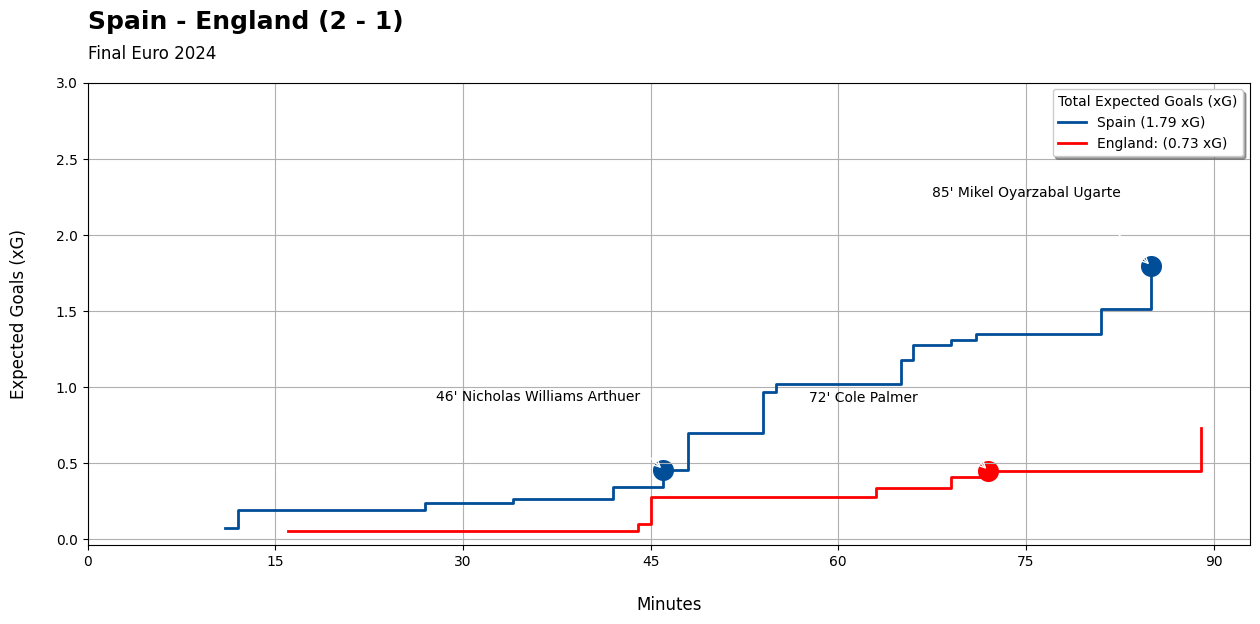

In [37]:
fig, ax = plt.subplots(figsize=(15,6))

# Create line plots
ax.step(x=h_xg['minute'], y=h_xg['h_cum'], where='post', color='#004d98', 
        label=hteam + " (" + h_total + " xG)", linewidth=2)
ax.step(x=a_xg['minute'], y=a_xg['a_cum'], where='post', color='red', 
        label=ateam + ": " + "(" + a_total + " xG)", linewidth=2)

# Use a circle ('o') as the marker for goals
goal_marker = 'o'

# Create scatter plot for highlighting the goal
ax.scatter(x=h_goal['minute'], y=h_goal['h_cum'], marker=goal_marker, s=200, color='#004d98')
ax.scatter(x=a_goal['minute'], y=a_goal['a_cum'], marker=goal_marker, s=200, color='red')

# Customize our chart with annotations
for j, txt in h_goal['scorechart'].items():
    ax.annotate(txt, (h_goal['minute'][j], h_goal['h_cum'][j]), xycoords='data', ha='center',
                xytext=(-90, 50), textcoords='offset points', 
                arrowprops=dict(arrowstyle="->", connectionstyle="arc,angleA=0,armA=50,rad=10", color='white'))

for i, txt in a_goal['scorechart'].items():
    ax.annotate(txt, (a_goal['minute'][i], a_goal['a_cum'][i]), xycoords='data', ha='center',
                xytext=(-90, 50), textcoords='offset points', 
                arrowprops=dict(arrowstyle="->", connectionstyle="arc,angleA=0,armA=50,rad=10", color='white'))

# Customize the chart
plt.xticks([0, 15, 30, 45, 60, 75, 90])
plt.yticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
plt.grid()

# Add titles and labels
fig.text(s=hteam + " - " + ateam + " (" + '2' + " - " + '1' + ")", x=0.125, y=0.97, fontsize=18, fontweight="bold")
fig.text(s='Final Euro 2024', x=0.125, y=0.92, fontsize=12)

# Add legend
legend = ax.legend(title='Total Expected Goals (xG)', loc='best', shadow=True)
legend._legend_box.align = "left"

plt.ylabel("Expected Goals (xG)", fontsize=12, labelpad=20)
plt.xlabel("Minutes", fontsize=12, labelpad=20)

plt.show()


## **Pitch Graph - xG by Location**  

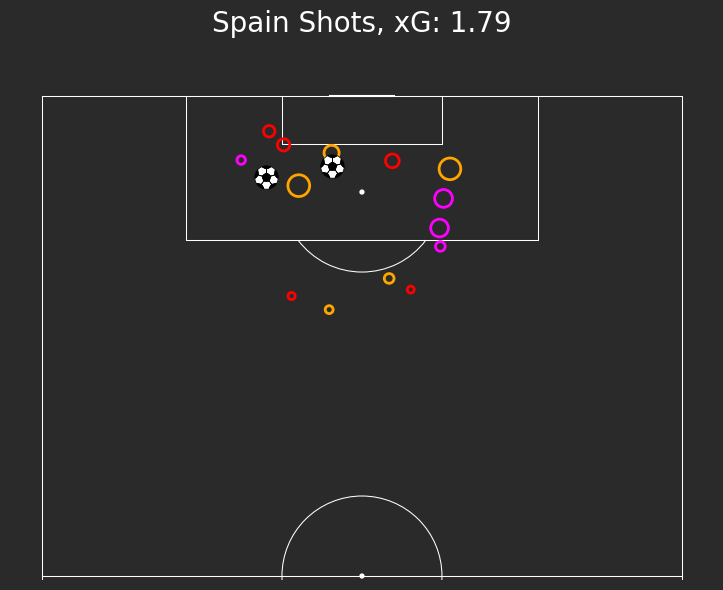

In [53]:
# Set up the pitch (without orientation) with a background color that matches the pitch
pitch_color = '#2a2a2a'  # Same color as the pitch
line_color = '#c7d5cc'   # Pitch lines color
pitch = VerticalPitch(
    pitch_type='statsbomb', 
    half=True, 
    pitch_color='#2a2a2a', 
    pad_bottom=.5, 
    line_color='white',
    linewidth=.75,
    axis=True, label=True
)

# Create the figure and axis
fig, ax = pitch.draw(figsize=(10, 6))  # Adjust the figsize as needed

# Loop over each shot to plot the bubbles with the required conditions
for i in range(len(shots_xg_home)):
    x, y = shots_xg_home.x[i], shots_xg_home.y[i]
    outcome = shots_xg_home.shot_outcome[i]
    size = 300 if outcome == 'Goal' else 1000 * shots_xg_home.shot_statsbomb_xg[i]
    
    if outcome == 'Goal':
        # For Goals: Full marker using football marker
        pitch.scatter(x, y, marker='football', s=size, ax=ax)
    else:
        # For other outcomes: Outline marker only
        if outcome == 'Blocked':
            color = 'red'
        elif outcome in ['Wayward', 'Off T']:
            color = 'orange'
        else:
            color = 'magenta'
        
        # Plot without filling the inside, only outline
        pitch.scatter(x, y, edgecolors=color, facecolors='none', linewidth=2, s=size, ax=ax)

# Set title
ax.set_title(f"{str(match_details['home_team'].iloc[0])} Shots, xG: {str(round(home_xg_cumu[-1], 2))}", 
             size=20, color='white')
ax.set_axis_off()
# Set the background color of the figure to match the pitch
fig.patch.set_facecolor(pitch_color)

# Display the plot
plt.show()

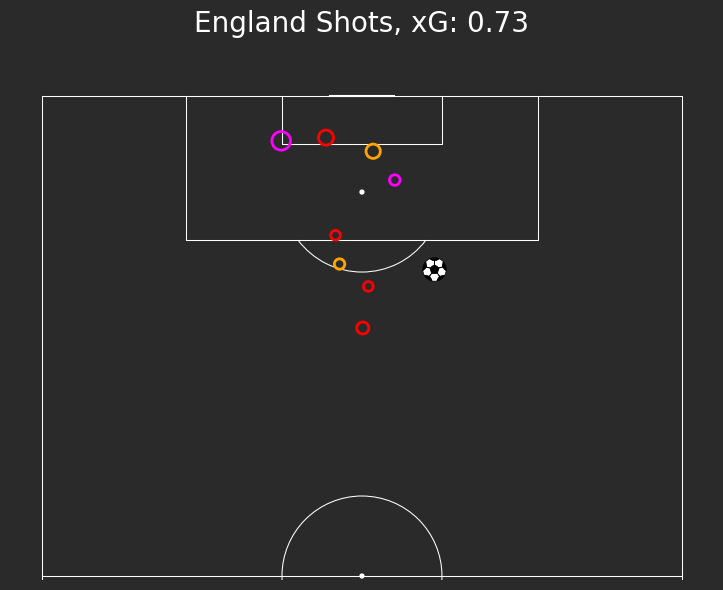

In [54]:
# Set up the pitch (without orientation) with a background color that matches the pitch
pitch_color = '#2a2a2a'  # Same color as the pitch
line_color = '#c7d5cc'   # Pitch lines color
pitch = VerticalPitch(
    pitch_type='statsbomb', 
    half=True, 
    pitch_color='#2a2a2a', 
    pad_bottom=.5, 
    line_color='white',
    linewidth=.75,
    axis=True, label=True
)



# Create the figure and axis
fig, ax = pitch.draw(figsize=(10, 6))  # Adjust the figsize as needed

# Loop over each shot to plot the bubbles with the required conditions
for i in range(len(shots_xg_away)):
    x, y = shots_xg_away.x[i], shots_xg_away.y[i]
    outcome = shots_xg_away.shot_outcome[i]
    size = 300 if outcome == 'Goal' else 1000 * shots_xg_away.shot_statsbomb_xg[i]
    
    if outcome == 'Goal':
        # For Goals: Full marker using football marker
        pitch.scatter(x, y, marker='football', s=size, ax=ax)
    else:
        # For other outcomes: Outline marker only
        if outcome == 'Blocked':
            color = 'red'
        elif outcome in ['Wayward', 'Off T']:
            color = 'orange'
        else:
            color = 'magenta'
        
        # Plot without filling the inside, only outline
        pitch.scatter(x, y, edgecolors=color, facecolors='none', linewidth=2, s=size, ax=ax)

# Set title
ax.set_title(f"{str(match_details['away_team'].iloc[0])} Shots, xG: {str(round(away_xg_cumu[-1], 2))}", 
             size=20, color='white')
ax.set_axis_off()

# Set the background color of the figure to match the pitch
fig.patch.set_facecolor(pitch_color)

# Display the plot
plt.show()

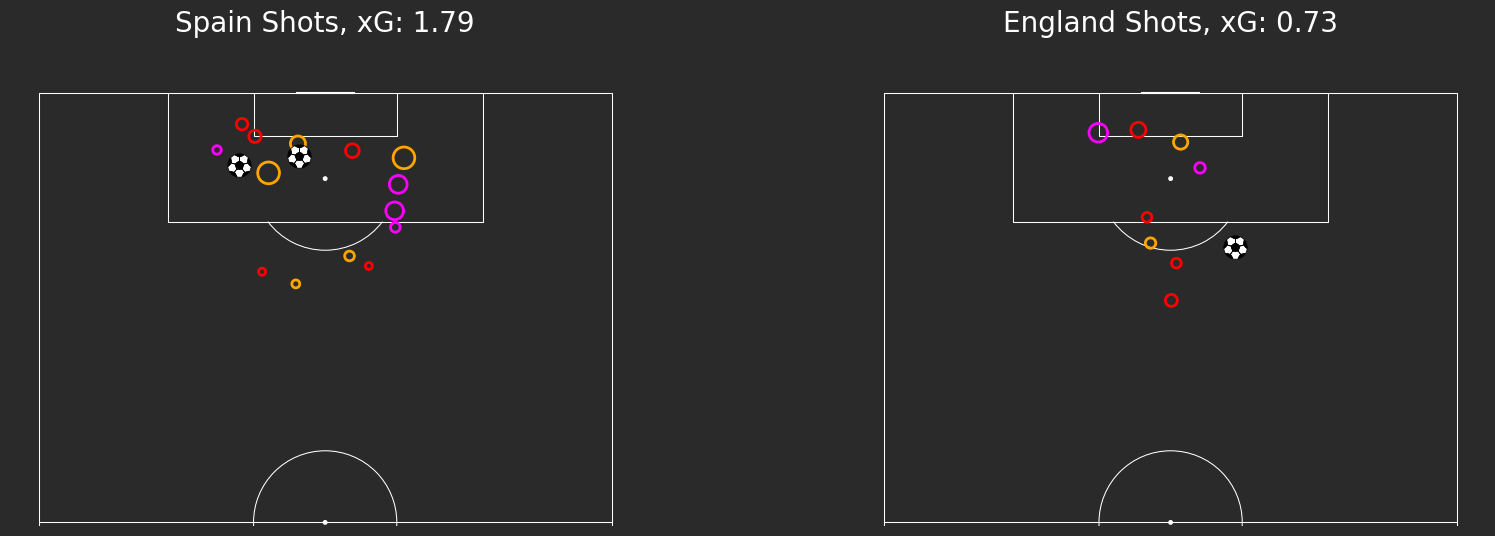

In [55]:
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt

# Set up the figure and axes for two side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))  # 1 row, 2 columns

# Home team plot
pitch_color = '#2a2a2a'  # Same color as the pitch
line_color = '#c7d5cc'   # Pitch lines color
pitch = VerticalPitch(
    pitch_type='statsbomb', 
    half=True, 
    pitch_color=pitch_color, 
    pad_bottom=.5, 
    line_color='white',
    linewidth=.75,
    axis=True, label=True
)

# Draw the home team pitch
pitch.draw(ax=ax1)

# Loop over each shot for the home team to plot the bubbles with the required conditions
for i in range(len(shots_xg_home)):
    x, y = shots_xg_home.x[i], shots_xg_home.y[i]
    outcome = shots_xg_home.shot_outcome[i]
    size = 300 if outcome == 'Goal' else 1000 * shots_xg_home.shot_statsbomb_xg[i]
    
    if outcome == 'Goal':
        # For Goals: Full marker using football marker
        pitch.scatter(x, y, marker='football', s=size, ax=ax1)
    else:
        # For other outcomes: Outline marker only
        if outcome == 'Blocked':
            color = 'red'
        elif outcome in ['Wayward', 'Off T']:
            color = 'orange'
        else:
            color = 'magenta'
        
        # Plot without filling the inside, only outline
        pitch.scatter(x, y, edgecolors=color, facecolors='none', linewidth=2, s=size, ax=ax1)

# Set title for the home team plot
ax1.set_title(f"{str(match_details['home_team'].iloc[0])} Shots, xG: {str(round(home_xg_cumu[-1], 2))}", 
             size=20, color='white')
ax1.set_axis_off()


# Away team plot
pitch.draw(ax=ax2)

# Loop over each shot for the away team to plot the bubbles with the required conditions
for i in range(len(shots_xg_away)):
    x, y = shots_xg_away.x[i], shots_xg_away.y[i]
    outcome = shots_xg_away.shot_outcome[i]
    size = 300 if outcome == 'Goal' else 1000 * shots_xg_away.shot_statsbomb_xg[i]
    
    if outcome == 'Goal':
        # For Goals: Full marker using football marker
        pitch.scatter(x, y, marker='football', s=size, ax=ax2)
    else:
        # For other outcomes: Outline marker only
        if outcome == 'Blocked':
            color = 'red'
        elif outcome in ['Wayward', 'Off T']:
            color = 'orange'
        else:
            color = 'magenta'
        
        # Plot without filling the inside, only outline
        pitch.scatter(x, y, edgecolors=color, facecolors='none', linewidth=2, s=size, ax=ax2)

# Set title for the away team plot
ax2.set_title(f"{str(match_details['away_team'].iloc[0])} Shots, xG: {str(round(away_xg_cumu[-1], 2))}", 
             size=20, color='white')
ax2.set_axis_off()

# Set the background color of the entire figure to match the pitch
fig.patch.set_facecolor(pitch_color)

# Display the plot
plt.show()
